# Building a convolutional neural network model to predict terminator strength

## Import modules and define functions

Import the required modules:

In [1]:
%matplotlib inline

import numpy as np
import eugene as eu
import pandas as pd
import glob
import os
import pathlib
import logomaker
import matplotlib
from matplotlib import pyplot as plt

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: NVIDIA GeForce GTX 1650


Configure EUGENe directories:

In [2]:
eu.settings.config_dir = "./configs" # Directory to specify when you want to load a model from a config file
eu.settings.dataset_dir = "./dataset" # Directory where EUGENe will download datasets to
eu.settings.logging_dir = "./logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
eu.settings.output_dir = "./output" # Directory where EUGENe will save output files to
eu.settings.figure_dir = "./figures" # Directory to specify to EUGENe to save figures to

pathlib.Path('figures').mkdir(exist_ok = True)

## Load and convert the data to the required format

Load the experimental data:

In [3]:
data_term = pd.read_csv('terminator_data.tsv', sep = '\t', header = 0).set_index('id')

Create a SeqData object:

In [4]:
term_SeqData = eu.dl.SeqData(
  seqs = data_term['sequence'],
  names = data_term.index,
  seqs_annot = data_term[['enrichment_tobacco', 'enrichment_maize', 'set', 'species']]
)

One-hot encode the sequences:

In [5]:
eu.pp.ohe_seqs_sdata(
    term_SeqData,
    vocab = 'DNA'
)

One-hot encoding sequences:   0%|          | 0/53409 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 53409 ohe_seqs added


Split data into training and test set:

In [6]:
term_train = term_SeqData[term_SeqData['set'] == 'train']
term_test = term_SeqData[term_SeqData['set'] == 'test']

Split the training set into training and validation:

In [7]:
eu.pp.train_test_split_sdata(
    term_train,
    train_key = 'train_val',
    split = 0.9
)

SeqData object modified:
    seqs_annot:
        + train_val


## Build the model

Load a model from a configuration file:

In [8]:
from DenseNet import DenseNet

config_name = 'DenseNet_terminators'
config_file = os.path.join(eu.settings.config_dir, config_name + '.yaml')

model = DenseNet.load_from_config(config_file)

Initialize the weights:

In [9]:
eu.settings.seed = 1

eu.models.init_weights(model)

Global seed set to 1


Train the model:

In [ ]:
eu.train.fit(
    model = model,
    sdata = term_train,
    gpus = 1,
    target_keys = ['enrichment_tobacco', 'enrichment_maize'],
    train_key = 'train_val',
    epochs = 50,
    batch_size = 128,
    num_workers = 12,
    version = config_name
)

Load the best-performing model checkpoint:

In [10]:
model_file = glob.glob(os.path.join(eu.settings.logging_dir, 'ssDenseNet_regression', config_name, 'checkpoints', '*'))[0]
best_model = DenseNet.load_from_checkpoint(model_file)

## Evalutate the model

Predict enrichment for the test set:

In [11]:
eu.evaluate.predictions(
    best_model,
    sdata = term_test,
    target_keys = ['enrichment_tobacco', 'enrichment_maize'],
    version = config_name,
    store_only = True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize.


/home/tobjores/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + enrichment_maize_predictions, enrichment_tobacco_predictions


Save predictions to a file:

In [12]:
term_test.seqs_annot.to_csv('terminator_data_predictions_test.tsv', sep = '\t')

Plot results:

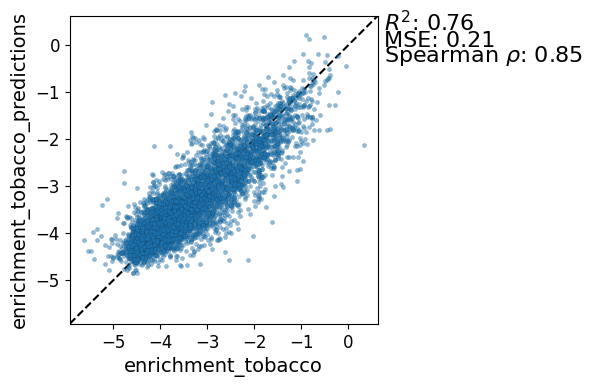

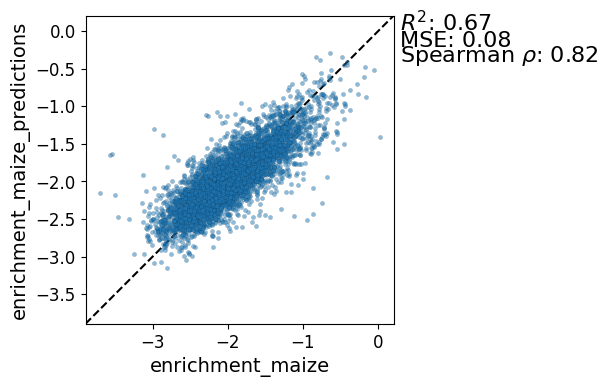

In [13]:
eu.pl.performance_scatter(
    term_test,
    target_keys = ['enrichment_tobacco', 'enrichment_maize'],
    prediction_keys = ['enrichment_tobacco_predictions', 'enrichment_maize_predictions'],
    alpha = 0.5,
    figsize = (4, 4)
)

Visualize salient features in top 5 sequences (using the tobacco model):

In [14]:
eu.interpret.feature_attribution_sdata(
    model = best_model,
    sdata = term_test,
    method = 'DeepLift',
    suffix = '_tobacco',
    target = 0 # 0 for tobacco; 1 for maize
)

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/41 [00:00<?, ?it/s]

/home/tobjores/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

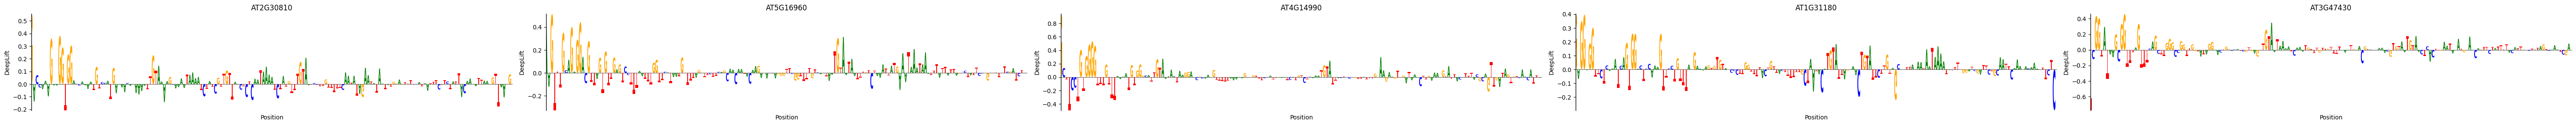

In [15]:
top5 = term_test['enrichment_tobacco_predictions'].sort_values(ascending = False).iloc[:5].index

eu.pl.multiseq_track(
    term_test,
    seq_ids = top5,
    uns_keys = 'DeepLift_imps_tobacco',
    ylabs = 'DeepLift',
    height = 3,
    width = 60
)

Save plots:

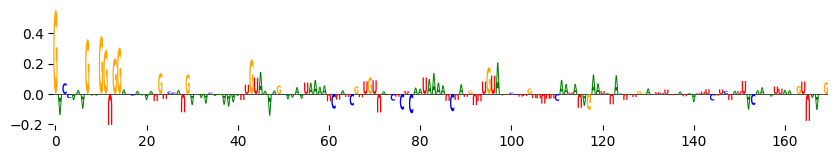

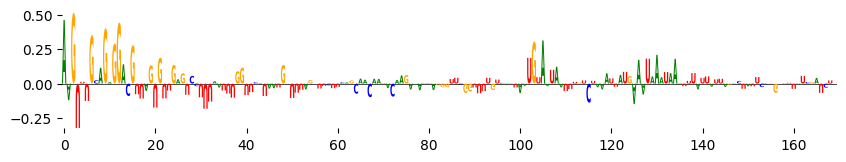

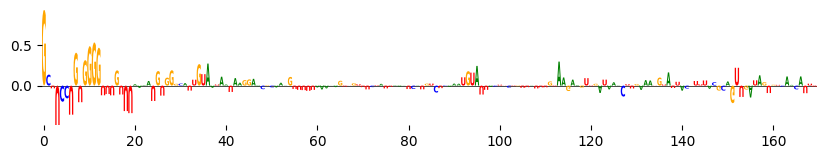

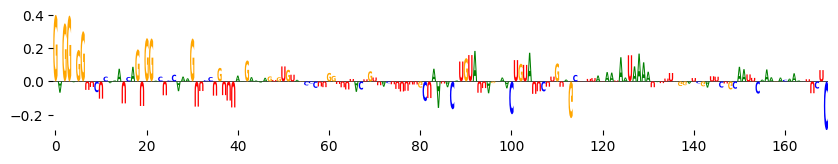

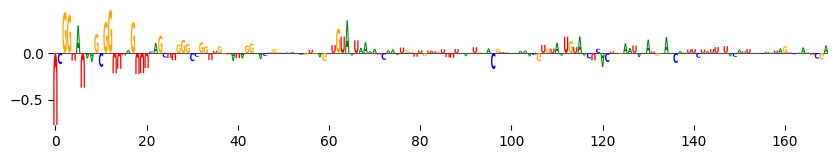

In [16]:
for terminator in top5:
    contrib_scores = term_test.uns['DeepLift_imps_tobacco'][term_test.names == terminator].squeeze().transpose(1, 0)

    fig = plt.figure(figsize = (10, 1.5))
    ax = fig.add_subplot(111) 

    df = pd.DataFrame(contrib_scores, columns = ['A', 'C', 'G', 'U'])
    df.index.name = 'pos'

    crp_logo = logomaker.Logo(df, ax = ax)
    crp_logo.style_spines(visible = False)

    plt.savefig(os.path.join(eu.settings.figure_dir, f'DeepLift_{terminator}_tobacco.pdf'))

Visualize salient features in top 5 sequences (using the maize model):

In [17]:
eu.interpret.feature_attribution_sdata(
    model = best_model,
    sdata = term_test,
    method = 'DeepLift',
    suffix = '_maize',
    target = 1 # 0 for tobacco; 1 for maize
)

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/41 [00:00<?, ?it/s]

/home/tobjores/.local/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

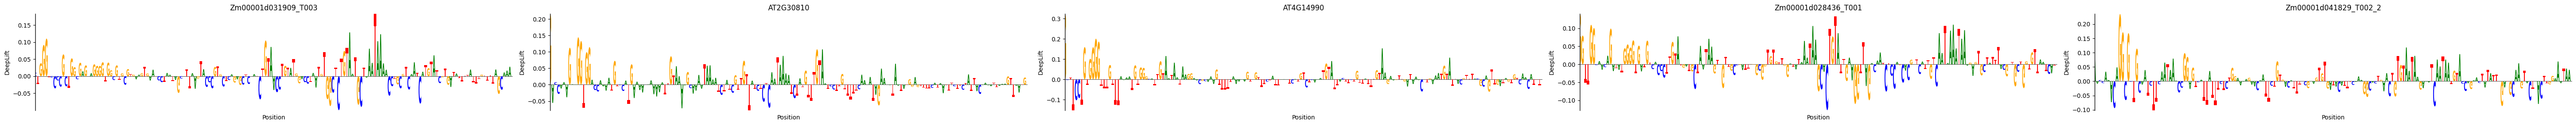

In [18]:
top5 = term_test['enrichment_maize_predictions'].sort_values(ascending = False).iloc[:5].index

eu.pl.multiseq_track(
    term_test,
    seq_ids = top5,
    uns_keys = 'DeepLift_imps_maize',
    ylabs = 'DeepLift',
    height = 3,
    width = 60
)

Save plots:

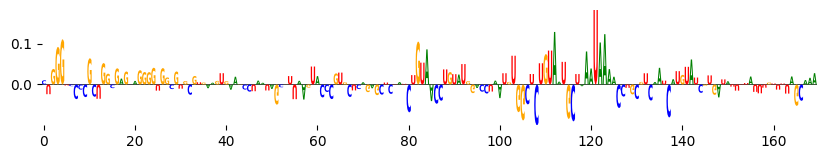

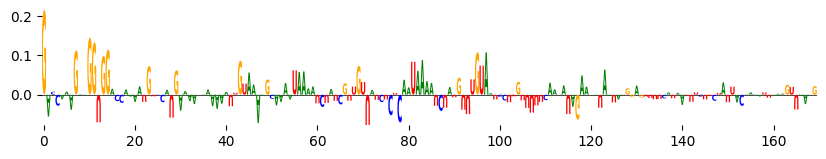

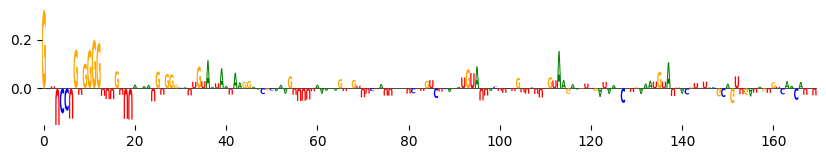

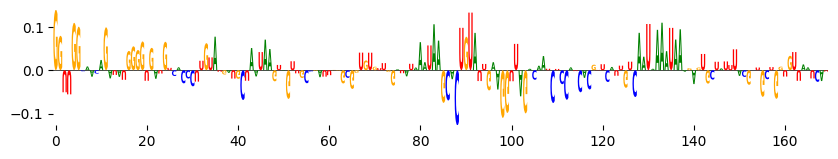

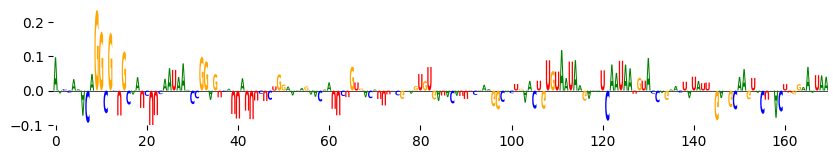

In [19]:
for terminator in top5:
    contrib_scores = term_test.uns['DeepLift_imps_maize'][term_test.names == terminator].squeeze().transpose(1, 0)

    fig = plt.figure(figsize = (10, 1.5))
    ax = fig.add_subplot(111) 

    df = pd.DataFrame(contrib_scores, columns = ['A', 'C', 'G', 'U'])
    df.index.name = 'pos'

    crp_logo = logomaker.Logo(df, ax = ax)
    crp_logo.style_spines(visible = False)

    plt.savefig(os.path.join(eu.settings.figure_dir, f'DeepLift_{terminator}_maize.pdf'))

Save one-hot encoded test sequences and DeepLift imputations for TF-MoDISCo analysis: